In [22]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yad2k.yolo_utily import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

In [23]:
cd E:\dog-breed-classifier

E:\dog-breed-classifier


In [25]:
# GRADED FUNCTION: yolo_filter_boxes

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """
    Filters YOLO boxes by thresholding on object and class confidence.
    
   
    """
    
    # Step 1: Compute box scores
    ### START CODE HERE ### (≈ 1 line)
    box_scores = tf.multiply(box_confidence,box_class_probs,name=None);
    ### END CODE HERE ###
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    ### START CODE HERE ### (≈ 2 lines)
    box_classes = K.argmax( box_scores,axis=-1,);
    box_class_scores =K.max(box_scores,axis=-1);
    ### END CODE HERE ###
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ### START CODE HERE ### (≈ 1 line)
    filtering_mask = (box_class_scores >= threshold);
    ### END CODE HERE ###
    
    # Step 4: Apply the mask to scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = tf.boolean_mask(mask=filtering_mask,tensor= box_class_scores);
    boxes =  tf.boolean_mask(mask=filtering_mask,tensor= boxes);
    classes = tf.boolean_mask(mask=filtering_mask,tensor= box_classes);
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [26]:
# GRADED FUNCTION: yolo_non_max_suppression

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
  
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max

    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ### START CODE HERE ### (≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes=boxes,scores=scores,max_output_size=max_boxes_tensor);
    ### END CODE HERE ###
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores =tf.gather(params=scores,indices=nms_indices);
    boxes = tf.gather(params=boxes,indices=nms_indices);
    classes = tf.gather(params=classes,indices=nms_indices);
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [27]:
# GRADED FUNCTION: yolo_eval

def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
   
    """
    
    ### START CODE HERE ### 
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_xy, box_wh,box_confidence, box_class_probs = yolo_outputs;

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    print(box_confidence)
    print(box_class_probs)
    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold =score_threshold);
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold );
    
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [28]:
sess=K.get_session()

In [29]:
class_names = read_classes("yad2k/model_data/coco_classes.txt")
anchors = read_anchors("yad2k/model_data/yolo_anchors.txt")
image_shape = (500., 500.)    

In [30]:
## This requires python 3.5  See https://github.com/keras-team/keras/issues/7297
yolo_model = load_model("yad2k/model_data/yolo.h5")

C:\Users\SANYAM\Anaconda3\envs\tensorflowproject\lib\site-packages\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [31]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [32]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [33]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Tensor("Sigmoid_1:0", shape=(?, ?, ?, 5, 1), dtype=float32)
Tensor("Reshape_6:0", shape=(?, ?, ?, 5, 80), dtype=float32)


In [34]:
def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
     
    """

    # Preprocess your image
    image, image_data = preprocess_image(image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    ### START CODE HERE ### (≈ 1 line)
    out_scores, out_boxes, out_classes = sess.run([scores,boxes,classes],feed_dict={yolo_model.input:image_data,K.learning_phase(): 0})
    ### END CODE HERE ###

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    
    # Save the predicted bounding box on the image
    
    output_image = scipy.misc.imread(image_file)
    imshow(image)
    
    return out_scores, out_boxes, out_classes

Found 3 boxes for yad2k/images/dog.jpg
dog 0.78 (89, 186) (210, 469)
truck 0.80 (301, 71) (452, 145)
bicycle 0.84 (53, 97) (361, 407)


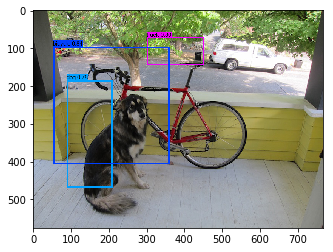

In [37]:
out_scores, out_boxes, out_classes = predict(sess, "yad2k/images/dog.jpg")